# Reproducing results from Florackis et Al

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk 
nltk.download('wordnet', quiet = True)
nltk.download('stopwords', quiet = True)
nltk.download('punkt', quiet = True)
nltk.download('words', quiet = True)

True

In [3]:
import pandas as pd
import numpy as np
import wrds
import glob
from tqdm.notebook import tqdm
from tqdm.dask import TqdmCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [4]:
#import functions from functions.py
from function_definitions import *

In [5]:
#connect to WRDS
db = wrds.Connection(wrds_username = 'danielceleny')
#db.create_pgpass_file()

Loading library list...
Done


## Get a list of all usable stock names

In [52]:
#import table about all available data series on wrds
stocknames = db.get_table(library='crsp', table = 'stocknames')
#change dates to datetime objects
stocknames.end_date = pd.to_datetime(stocknames.end_date)
stocknames.st_date = pd.to_datetime(stocknames.st_date)
#keep only their most recent ticker and Name
stocknames = stocknames[stocknames.nameenddt == stocknames.end_date]
stocknames = stocknames[['ticker','comnam','permco','st_date','end_date']]
#get rid of duplicate ticker and permco stocks
stocknames = stocknames[stocknames.ticker.notnull()]
stocknames.sort_values('end_date', ascending = False, inplace = True)
to_drop = []
#keep the observation that has the most recent observation
#if there are several, keep one one with the oldest observation
duplicated_tickers = stocknames[stocknames.duplicated(subset = 'ticker')].ticker.unique()
for ticker in duplicated_tickers:
    sn = stocknames[stocknames.ticker == ticker]
    sn = sn[sn.end_date == sn.end_date.max()]
    if len(sn) > 1:
        sn = sn[sn.st_date == sn.st_date.min()]
    to_keep = sn.index.values[0]
    indexes = stocknames[stocknames.ticker == ticker].index.values
    to_drop.append(indexes[~np.isin(indexes, to_keep)])
duplicated_permcos = stocknames[stocknames.duplicated(subset = 'permco')].permco.values
for permco in duplicated_permcos:
    sn = stocknames[stocknames.permco == permco]
    sn = sn[sn.end_date == sn.end_date.max()]
    if len(sn) > 1:
        sn = sn[sn.st_date == sn.st_date.min()]
    to_keep = sn.index.values[0]
    indexes = stocknames[stocknames.permco == permco].index.values
    to_drop.append(indexes[~np.isin(indexes, to_keep)])

to_drop = np.concatenate(to_drop).ravel()
stocknames = stocknames.drop(labels = to_drop)
stocknames.reset_index(inplace = True, drop = True)

print("Number of available time series: ", len(stocknames))
stocknames.head()

Number of available time series:  23688


,ticker,comnam,permco,st_date,end_date
0,TSLA,TESLA INC,53453.0,2010-06-29,2022-12-30
1,ZH,ZHIHU INC,58050.0,2021-03-26,2022-12-30
2,QFTA,QUANTUM FINTECH ACQ CORP,57870.0,2021-03-10,2022-12-30
3,STRC,SARCOS TECH & ROBOTICS CORP,57692.0,2021-03-08,2022-12-30
4,SEMR,SEMRUSH HOLDINGS INC,58043.0,2021-03-25,2022-12-30


## Find the CIK for all stocks

In [53]:
#read in the txt file linking tickers to CIKs
CIK = pd.read_csv('../data/ticker_to_CIK.txt', delimiter = "\t", header = None, names = ['ticker', 'CIK'], na_filter = False)
CIK.ticker = CIK.ticker.str.upper()
#CIK = CIK.set_index('ticker')
CIK

,ticker,CIK
0,AAPL,320193
1,MSFT,789019
2,BRK-B,1067983
3,UNH,731766
4,JNJ,200406
...,...,...
12079,HCICU,1829455
12080,HCICW,1829455
12081,HAWLM,46207
12082,HBANM,49196


In [54]:
#stocknames = stocknames.set_index('ticker')
stocknames = stocknames.merge(CIK, on = 'ticker', how = 'left')
#save stocknames as a gzipped csv
stocknames.to_csv("../data/stocknames.csv.gz", index = False)

print("Number of time series with an identified CIK: ", len(stocknames[~stocknames.CIK.isnull()]))
stocknames.head()

Number of time series with an identified CIK:  7077


,ticker,comnam,permco,st_date,end_date,CIK
0,TSLA,TESLA INC,53453.0,2010-06-29,2022-12-30,1318605.0
1,ZH,ZHIHU INC,58050.0,2021-03-26,2022-12-30,1835724.0
2,QFTA,QUANTUM FINTECH ACQ CORP,57870.0,2021-03-10,2022-12-30,1830795.0
3,STRC,SARCOS TECH & ROBOTICS CORP,57692.0,2021-03-08,2022-12-30,1826681.0
4,SEMR,SEMRUSH HOLDINGS INC,58043.0,2021-03-25,2022-12-30,1831840.0


## Download all 10-k urls from the SEC

In [60]:
#save the urls to all 10-K fillings
years = np.arange(2007,2023) # 2007 to 2022
#year represents the calendar year during which the statement was filed
for year in tqdm(years):
    get_idx_files(year, "../data/SEC_idx_files/", "10-K")
    
clear_output()
print('Done')

Done


## Find the urls of the 10-K disclosures for all stocks

In [59]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.CIK = pd.to_numeric(stocknames.CIK, errors = 'coerce')
#paths to the previously saved 10-K files
files_10k = np.sort(glob.glob("../data/SEC_idx_files/10-K/*"))

In [60]:
#find the url of the 10-K statement corresponding to each ticker in the dataset
years = np.arange(2007,2023) # 2007 to 2022
for file, year in zip(files_10k, years):
    with open(file, "r") as f:
        tenKs = f.read()
    
    lines = tenKs.split('\n')
    allpromises = []
    
    for line in lines[:-1]:
        allpromises.append(get_url(line))
    
    with TqdmCallback(desc = 'Finding urls for {}'.format(year)):
        temp = dask.compute(allpromises)
    
    #merge the resulting dictionnaries into one
    temp = {key: val for dict_ in temp[0] for key, val in dict_.items()}
    temp_df = pd.DataFrame(temp).T.reset_index()
    temp_df.columns = ['CIK', 'url_{}'.format(year), 'filling_date_{}'.format(year), 'comnam']
    temp_df.CIK = temp_df.CIK.astype(int)
    #merge the urls and filling dates onto the stocknames dataframe
    #merge on CIK when CIK is available
    stocknames = stocknames.merge(temp_df[['CIK', 'url_{}'.format(year), 'filling_date_{}'.format(year)]],
                                  on = 'CIK', how = 'left')
    #merge on company name when CIK is not available
    stocknames = stocknames.merge(temp_df[~np.isin(temp_df.CIK,stocknames.CIK)],
                                          on = 'comnam', how = 'left')
    stocknames['CIK']= stocknames.CIK_x.combine_first(stocknames.CIK_y)
    stocknames['url_{}'.format(year)] = stocknames['url_{}_x'.format(year)].combine_first(stocknames['url_{}_y'.format(year)])
    stocknames['filling_date_{}'.format(year)] = stocknames['filling_date_{}_x'.format(year)].combine_first(stocknames['filling_date_{}_y'.format(year)])
    stocknames.drop(columns = ['CIK_x', 'CIK_y','filling_date_{}_x'.format(year),'url_{}_y'.format(year),
                               'filling_date_{}_y'.format(year),'url_{}_x'.format(year)], inplace = True)
    clear_output()
    
print('Done')

Done


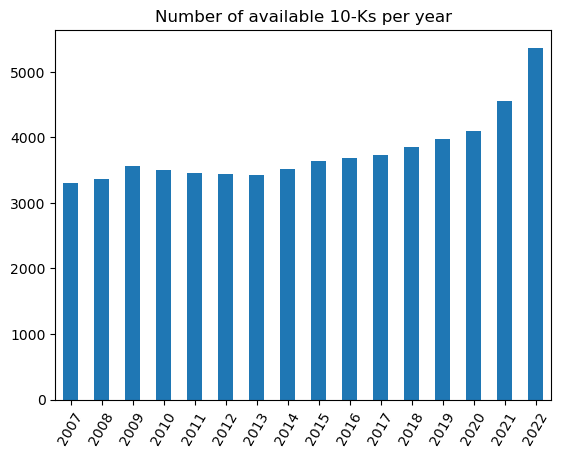

Number of firms with at least one observation: 7059
Number of firm-year observations: 60470
Number of time series with an identified CIK:  8695


In [61]:
#plot number of available 10-Ks
stocknames = stocknames[np.sort(stocknames.columns)]
nb_obs_per_year = (~stocknames.filter(like = 'url').isnull()).sum(0)
nb_obs_per_year.plot.bar()
plt.xticks(np.arange(16),years)
plt.title('Number of available 10-Ks per year')
plt.xticks(rotation = 60)
plt.show()
nb_obs_per_firm = (~stocknames.filter(like = 'url').isnull()).sum(1)
print('Number of firms with at least one observation: {}'.format((nb_obs_per_firm>0).sum()))
print('Number of firm-year observations: {}'.format(nb_obs_per_year.sum()))
print("Number of time series with an identified CIK: ", len(stocknames[~stocknames.CIK.isnull()]))

In [63]:
#drop firms with no obserations
idx = stocknames.filter(like = 'url').dropna(how = 'all').index
stocknames = stocknames.loc[idx,:]
#save stocknames as a gzipped csv
stocknames.to_csv("../data/stocknames.csv.gz", index = False)

## Read in 10-K statements, identify "Item 1A. Risk Factors"

In [64]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)

In [67]:
#might crash, if it does, just restart from the year that crashed
#save risk disclosures
years = np.arange(2007,2023)
for year in years[6:]:
    #consider only firms with a url for the given year
    temp = stocknames['url_{}'.format(year)].copy()
    idx = temp.dropna().index
    allpromises = []
    for i in idx:
        url = stocknames.loc[i,'url_{}'.format(year)]#.values[0]
        ticker = stocknames.iloc[i,:].ticker
        allpromises.append(find_risk_factors(url, ticker))
    with TqdmCallback(desc = 'Extracting risk factor statements for {}'.format(year)):
        raw_1as = dask.compute(allpromises)[0]
    #save the statements
    for raw_1a in raw_1as:
        save_text(year, "../data/risk_factor_statements/raw_risk_statements/", raw_1a)
    clear_output()
    
print('Done')

Done


In [68]:
#read in the risk disclosures
path = "../data/risk_factor_statements/raw_risk_statements/"
years = np.arange(2007,2023)
nb_firms = []
nb_not_found = []
for year in years:
    with open(path+"{}_item_1a.txt".format(year),"r", errors="replace") as file:
        raw_1a = file.read()
    raw_1as = re.split('=====[^=]+=====\n\n\n',raw_1a)
    #number of firms
    nb_firms.append(len(raw_1as))
    #number of firms with no identifiable risk disclosure
    not_founds = re.findall('ITEM 1A NOT FOUND', raw_1a)
    nb_not_found.append(len(not_founds))

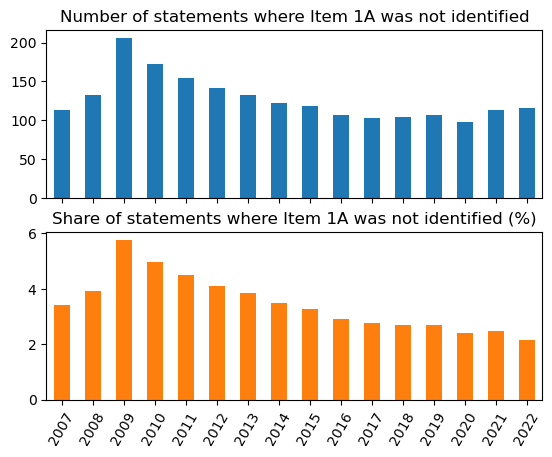

Number of firm-year observations: 58445


In [69]:
#plot number and share of missing data
nb_not_found = pd.DataFrame(nb_not_found, index = years)
nb_firms = pd.DataFrame(nb_firms, index = years)
df = pd.concat([nb_not_found,nb_not_found/nb_firms*100], axis = 1)
df.columns = ['Number of statements where Item 1A was not identified',
              'Share of statements where Item 1A was not identified (%)']
ax1, ax2 = df.plot.bar(subplots = True,legend=False)
ax2.tick_params('x',labelrotation=60)
plt.show()

nb_obs = nb_firms.sum()-nb_not_found.sum()
print('Number of firm-year observations: {}'.format(nb_obs.values[0]))

## Identify cybersecurity related sentences in the Risk factor statements

In [70]:
#read in the cyber keywords
cyber_keywords = pd.read_excel('../data/Florackis_dict_events/Cyber_Keywords.xlsx', header = 2)
cyber_keywords.dropna(axis = 1, how = 'all', inplace = True)
cols_to_fix = ['Keyword','Relevant_hit','Irrelevant_hit']
#cyber_keywords[cols_to_fix] = cyber_keywords[cols_to_fix].fillna('')
cyber_keywords.head()

,description,type,Keyword,Relevant_hit,Irrelevant_hit
0,direct,NaN,attack,cyber,terror
1,direct,NaN,attack,network,terrorist
2,direct,NaN,attack,system,war
3,direct,NaN,attack,product,contraband
4,direct,NaN,attack,services,bomb


In [77]:
#read the raw risk disclosures and save the cybersecurity related sentences
read_path = "../data/risk_factor_statements/raw_risk_statements/"
save_path = "../data/risk_factor_statements/cyber_risk_sentences/"
years = np.arange(2007,2023)
for year in years[12:]:
    #read in the disclosures for a given year
    with open(read_path+"{}_item_1a.txt".format(year),"r", errors="replace") as file:
        raw_1as = file.read()
    raw_1as = re.split('=====[^=]+=====\n\n\n',raw_1as)[:-1]
    #save the cybersecurity related sentences
    allpromises = []
    no_item1a_tickers = []
    for raw_1a in raw_1as:
        #filter out the firms with no item 1a 
        if re.search('ITEM 1A NOT FOUND',raw_1a):
            ticker = re.findall('=====([^=]+)=====', raw_1a)[0]
            no_item1a_tickers.append(ticker)
            continue
        allpromises.append(find_cybersecurity_sentences(raw_1a, cyber_keywords))
    
    with TqdmCallback(desc = 'Saving cybersecurity related sentences for {}'.format(year)):
        cyber_sentences = dask.compute(allpromises)[0]
    
    #add the firms with no item 1a
    for ticker in no_item1a_tickers:
        cyber_sentences.append(format_('ITEM 1A NOT FOUND', ticker))
        
    #save the statements
    for sentence in cyber_sentences:
        save_text(year, save_path, sentence, item1a = False)
    clear_output()
    
print('Done')

Done


In [78]:
#read in the cyber security related sentences
path = "../data/risk_factor_statements/cyber_risk_sentences/"
years = np.arange(2007,2023)
nb_firms = []
nb_no_cyber = []
for year in years:
    with open(path+"{}_cyber_sentences.txt".format(year),"r", errors="replace") as file:
        cyber_sentences = file.read()
    cyber_sentences_per_firm = re.split('=====[^=]+=====\n\n\n',cyber_sentences)
    #number of firms
    nb_firms.append(len(cyber_sentences_per_firm)-1)
    #number of firms with no identifiable cybersecurity related sentences
    no_cyber = re.findall('NO CYBER RELATED SENTENCES', cyber_sentences)
    nb_no_cyber.append(len(no_cyber))

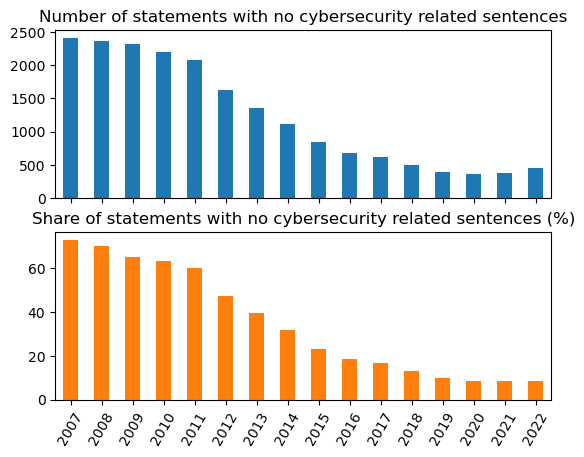

Number of firm-year observations with cybersecurity related sentences: 40808


In [79]:
#plot number and share of companies with no cyber related sentences
nb_no_cyber = pd.DataFrame(nb_no_cyber, index = years)
nb_firms = pd.DataFrame(nb_firms, index = years)
df = pd.concat([nb_no_cyber,nb_no_cyber/nb_firms*100], axis = 1)
df.columns = ['Number of statements with no cybersecurity related sentences',
              'Share of statements with no cybersecurity related sentences (%)']
ax1, ax2 = df.plot.bar(subplots = True,legend=False)
ax2.tick_params('x',labelrotation=60)
plt.show()

nb_obs = nb_firms.sum() - nb_no_cyber.sum()
print('Number of firm-year observations with cybersecurity related sentences: {}'.format(nb_obs.values[0]))

## Build the cybersecurity measure based on similarity between disclosures

In [80]:
#read the raw risk disclosures and save the cybersecurity related sentences
read_path = "../data/risk_factor_statements/cyber_risk_sentences/"
save_path = "../data/risk_factor_statements/cyber_risk_words/"
years = np.arange(2007,2023)
for year in years:
    #read in the cybersecurity related sentences
    with open(read_path+"{}_cyber_sentences.txt".format(year),"r", errors="replace") as file:
        cyber_sentences = file.read()
    cyber_sentences = re.split('=====[^=]+=====\n\n\n',cyber_sentences)[:-1]
    #tokenize sentences into words and apply stemming, using both direct and indirect sentences
    tokens = []
    no_cyber_tickers = []
    print('Tokenizing {} using all sentences'.format(year))
    
    for cyber_s in tqdm(cyber_sentences):
        ticker = re.findall('=====([^=]+)=====', cyber_s)[0]
        cyber_s = re.sub('=====([^=]+)=====', '', cyber_s)
        #remove leading and trailing whitespaces
        cyber_s = cyber_s.strip()
        if re.search('NO CYBER RELATED SENTENCES', cyber_s):
            no_cyber_tickers.append(ticker)
            continue
        if re.search('ITEM 1A NOT FOUND',cyber_s):
            continue
            
        tokens.append(pd.DataFrame(clean(cyber_s, remove_html = False, stemming = True,
                                         remove_common = True), columns = [ticker]))
        
    #merge the tokens for each firm into a single dataframe
    tokens_df = pd.concat(tokens,axis = 1)
    #transform the dataframe to be collection of the term frequency vectors
    tokens_df = tokens_df.apply(pd.value_counts).fillna(0)
    #As in Florackis, remove tokens with frequency < 10
    tokens_df = tokens_df[tokens_df.sum(axis = 1)>10]
    
    #add the firms with no cybersecurity related sentences with a column of zeros
    for ticker in no_cyber_tickers:
        tokens_df[ticker] = 0
    tokens_df.to_csv(save_path+"{}_term_frequency_full.csv".format(year))
    clear_output()
    
    #tokenize sentences into words and apply stemming, using only direct sentences
    cyber_sentences = [re.split("\n\n", cs)[0] for cs in cyber_sentences]
    tokens = []
    no_cyber_tickers = []
    print('Tokenizing {} using direct sentences'.format(year))
    
    for cyber_s in tqdm(cyber_sentences):
        ticker = re.findall('=====([^=]+)=====', cyber_s)[0]
        cyber_s = re.sub('=====([^=]+)=====', '', cyber_s)
        #remove leading and trailing whitespaces
        cyber_s = cyber_s.strip()
        if re.match('NO CYBER RELATED SENTENCES', cyber_s):
            no_cyber_tickers.append(ticker)
            continue
        if re.search('ITEM 1A NOT FOUND',cyber_s):
            continue
            
        tokens.append(pd.DataFrame(clean(cyber_s, remove_html = False, stemming = True, 
                                         remove_common = True), columns = [ticker]))
        
    #merge the tokens for each firm into a single dataframe
    tokens_df = pd.concat(tokens,axis = 1)
    #transform the dataframe to be collection of the term frequency vectors
    tokens_df = tokens_df.apply(pd.value_counts).fillna(0)
    #As in Florackis, remove tokens with frequency < 10
    tokens_df = tokens_df[tokens_df.sum(axis = 1)>10]
    
    #add the firms with no cybersecurity related sentences with a column of zeros
    for ticker in no_cyber_tickers:
        tokens_df[ticker] = 0
    tokens_df.to_csv(save_path+"{}_term_frequency_direct.csv".format(year))
    clear_output()
    
print('Done')

Done


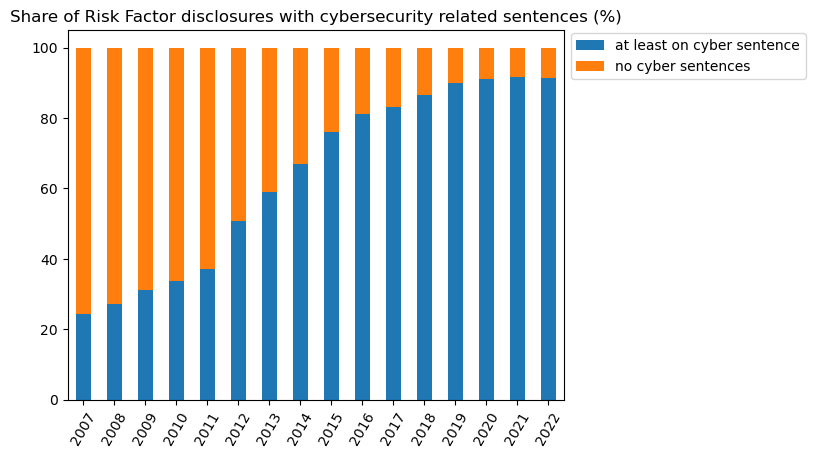

Share of firms with zero risk in 2011: 62.84%
Share of firms with zero risk in 2018: 13.36%


In [81]:
#plot the proportion of statements with cybersecurity related sentences
read_path = "../data/risk_factor_statements/cyber_risk_words/"
value_counts = []
most_common_words = []
years = np.arange(2007,2023)
for year in years:
    tokens_df = pd.read_csv(read_path + "{}_term_frequency_full.csv".format(year), index_col = 0)
    most_common_words.append(tokens_df)
    vc = tokens_df.sum(axis = 0).apply(
        lambda x: 'no cyber sentences' if x < 1 else 'at least on cyber sentence').value_counts()
    value_counts.append(pd.DataFrame(vc))
value_counts = pd.concat(value_counts, axis = 1).T
value_counts.index = years
value_counts = value_counts.div(value_counts.sum(axis = 1), axis = 0)*100
value_counts[['at least on cyber sentence','no cyber sentences']].plot(kind='bar', stacked=True)
plt.title('Share of Risk Factor disclosures with cybersecurity related sentences (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xticks(rotation = 60)
plt.show()
print('Share of firms with zero risk in 2011: {}%'.format(round(value_counts.loc[2011,'no cyber sentences'],2)))
print('Share of firms with zero risk in 2018: {}%'.format(round(value_counts.loc[2018,'no cyber sentences'],2)))

In [82]:
#show the top 20 most common words (after stemming) in the full texts
most_common_words = pd.concat(most_common_words, axis = 1, ignore_index = True)
most_common_words = most_common_words.sum(axis = 1).sort_values(ascending = False)
print('Top 20 most common words in direct and indirect sentences (nb occurrances)')
print(most_common_words.head(20).to_string())
print('Universe of all words in the sample is {}.'.format(len(most_common_words)))

Top 20 most common words in direct and indirect sentences (nb occurrances)
busi         325356.0
may          310963.0
oper         303492.0
inform       289079.0
result       285500.0
system       262533.0
secur        257912.0
data         191835.0
advers       188014.0
financi      174590.0
includ       160260.0
breach       156927.0
custom       156120.0
servic       154796.0
product      133219.0
affect       125344.0
parti        119336.0
technolog    117813.0
materi       112892.0
compani      111149.0
Universe of all words in the sample is 4494.


In [84]:
#show the top 20 most common words (after stemming) in the direct texts
read_path = "../data/risk_factor_statements/cyber_risk_words/"
value_counts = []
most_common_words = []
years = np.arange(2007,2023)
for year in years:
    tokens_df = pd.read_csv(read_path + "{}_term_frequency_direct.csv".format(year), index_col = 0)
    most_common_words.append(tokens_df)
most_common_words = pd.concat(most_common_words, axis = 1, ignore_index = True)
most_common_words = most_common_words.sum(axis = 1).sort_values(ascending = False)
print('Top 20 most common words in direct sentences (nb occurrances)')
print(most_common_words.head(20).to_string())
print('Universe of all words in the sample is {}.'.format(len(most_common_words)))

Top 20 most common words in direct sentences (nb occurrances)
secur        174253.0
system       160910.0
inform       158439.0
breach       140133.0
may          124152.0
busi         110053.0
result       107033.0
oper         103752.0
data          97702.0
attack        92501.0
includ        78130.0
cyber         75994.0
custom        69214.0
disrupt       66281.0
servic        65768.0
technolog     61624.0
parti         60744.0
risk          59013.0
unauthor      58406.0
failur        58377.0
Universe of all words in the sample is 2994.


In [85]:
list_hacked_firms = pd.read_excel('../data/Florackis_dict_events/data_breaches.xlsx')
list_hacked_firms = list_hacked_firms[list_hacked_firms.Ticker.notnull()]
#only retain hacks
list_hacked_firms = list_hacked_firms[np.isin(list_hacked_firms.Method,['hacked', 'poor security'])]
list_hacked_firms.head()

,Entity,Ticker,Parent_ticker,Date,Year,Records,Organization type,Method
0,21st Century Oncology,LLC,NaN,2016-03-07,2016,2200000,healthcare,hacked
3,Adobe Systems Incorporated,ADBE,NaN,2013-10-03,2013,152000000,tech,hacked
4,Adobe Inc.,ADBE,NaN,2019-10-25,2019,7500000,tech,poor security
9,Air Canada,AC,NaN,NaT,2018,20000,transport,hacked
13,Animal Jam,NAZARA,NAZARA,2020-11-16,2020,46000000,gaming,hacked


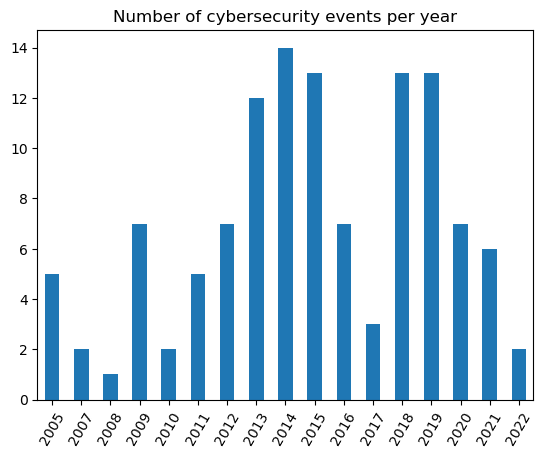

Total number of cybersecurity events: 119


In [86]:
list_hacked_firms.Year.value_counts().sort_index().plot.bar()
plt.title('Number of cybersecurity events per year')
plt.xticks(rotation = 60)
plt.show()
print('Total number of cybersecurity events: {}'.format(len(list_hacked_firms)))

In [87]:
#compute the cyber risk metrics
read_path = "../data/risk_factor_statements/cyber_risk_words/"
full_cyber_risk = []
direct_cyber_risk = []
years = np.arange(2007,2023)
for year in years:
    full_tokens_df = pd.read_csv(read_path + "{}_term_frequency_full.csv".format(year), index_col = 0)
    dir_tokens_df = pd.read_csv(read_path + "{}_term_frequency_direct.csv".format(year), index_col = 0)
    filling_dates = stocknames[['filling_date_{}'.format(year), 'ticker']].set_index('ticker')
    
    print('Computing cyber risk measures for {}'.format(year))
    cyber_risk_full = {}
    cyber_risk_dir = {}
    for firm in tqdm(full_tokens_df.columns.values):
        cosine_sims_full = []
        cosine_sims_dir = []
        
        #filling date of the firm
        fd = pd.to_datetime(filling_dates.loc[firm].values[0])
        #training sample = firms hacked in year prior
        training_sample = list_hacked_firms[(list_hacked_firms.Date < fd) &
                                            (list_hacked_firms.Date >= fd - pd.DateOffset(years=1))].Ticker.values
        
        #if no firms hacked in year prior, #training sample = firms hacked in two prior years
        no_events = False
        if not len(training_sample) or not np.isin(training_sample, full_tokens_df.columns.values).any():
            training_sample = list_hacked_firms[(list_hacked_firms.Date < fd) &
                                            (list_hacked_firms.Date >= fd - pd.DateOffset(years=2))].Ticker.values
            no_events = True
        

        #if there are not many events, take two years worth of observations
        if np.sum(np.isin(training_sample, full_tokens_df.columns.values)) < 8:
            if no_events:
                training_sample = list_hacked_firms[(list_hacked_firms.Date < fd) &
                                            (list_hacked_firms.Date >= fd - pd.DateOffset(years=3))].Ticker.values
            else:
                training_sample = list_hacked_firms[(list_hacked_firms.Date < fd) &
                                            (list_hacked_firms.Date >= fd - pd.DateOffset(years=2,
                                                                                          months = 6))].Ticker.values
        
        #calculate cosine similarity
        for training_firm in training_sample:
            try:
                cosine_sims_full.append(cosine_similarity([full_tokens_df[firm].values],
                                                          [full_tokens_df[training_firm]]))
            except:
                None
            try:
                cosine_sims_dir.append(cosine_similarity([dir_tokens_df[firm].values],
                                                         [dir_tokens_df[training_firm]]))
            except:
                None
        
        cyber_risk_full[firm] = np.mean(cosine_sims_full)
        cyber_risk_dir[firm] = np.mean(cosine_sims_dir)
        
    full_cyber_risk.append(cyber_risk_full)
    direct_cyber_risk.append(cyber_risk_dir)
    clear_output()
    
full_cyber_risk = pd.DataFrame(full_cyber_risk, index = years)
full_cyber_risk.index.rename('date', inplace = True)
direct_cyber_risk = pd.DataFrame(direct_cyber_risk, index = years)
direct_cyber_risk.index.rename('date', inplace = True)
print('Done')

Done


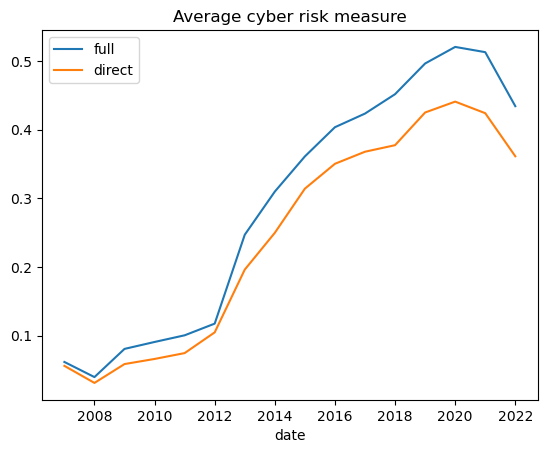

In [88]:
#plot the average cyber risk for every year
ax = full_cyber_risk.mean(1).plot()
direct_cyber_risk.mean(1).plot(ax = ax)
plt.title('Average cyber risk measure')
plt.legend(['full','direct'])
plt.show()

In [89]:
#save the risk measures
save_path = '../data/cyber_risk_measures/Florackis/'
full_cyber_risk.to_csv(save_path+'cosine_sim_full.csv')
direct_cyber_risk.to_csv(save_path+'cosine_sim_dir.csv')

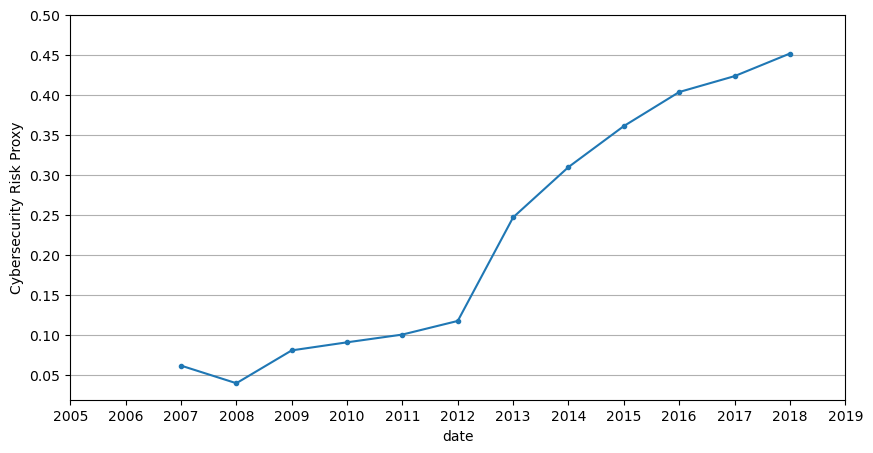

In [35]:
save_path = '../data/cyber_risk_measures/Florackis/'
full_cyber_risk = pd.read_csv(save_path+'cosine_sim_full.csv', index_col = 'date')
full_cyber_risk.mean(1).iloc[:-4].plot(style = '.-',figsize = (10,5),
                                       yticks = np.arange(0.05,0.55,0.05), xticks = np.arange(2005,2020)).grid(axis = 'y')
plt.ylabel('Cybersecurity Risk Proxy')
plt.show()

## Get stock returns

In [7]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)

In [96]:
#get monthly stock returns for all firms using wrds and crsp
returns = []
market_caps = []
industry_codes = []
print('Getting monthly returns for all firms')
for i in tqdm(range(len(stocknames))):
    ret = get_returns(stocknames.permco[i],db, stocknames.st_date[i], stocknames.end_date[i],stocknames.ticker[i])
    returns.append(ret[0])
    industry_codes.append(ret[1])
    market_caps.append(ret[2])

Getting monthly returns for all firms


  0%|          | 0/7059 [00:00<?, ?it/s]

In [97]:
returns_df = pd.concat(returns, axis = 1).sort_index()
returns_df.tail()

,TSLA,QFTA,STRC,SEMR,TLGA,AGAC,DNZ,FATH,BLUA,PRPC,...,FLYD,BCRD,MSPC,MSTC,HRST,GWIN,CLCN,BRVO,BRER,ATDS
date,,,,,,,,,,,,,,,,,,,,,
2022-08,-0.072489,-0.002530,-0.020896,0.009046,-0.003039,0.003049,0.000000,-0.112150,-0.001013,-0.001010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,-0.037589,0.000507,-0.323171,-0.086390,0.002032,0.003039,0.001014,-0.465789,0.005578,0.004044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10,-0.142168,0.006085,-0.090090,0.090990,0.009128,0.006061,0.013171,0.251232,0.004539,0.007049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11,-0.144326,0.000504,-0.423267,-0.224857,0.012060,0.003514,0.003500,-0.043307,0.004016,0.006000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12,-0.367334,0.012594,-0.518197,-0.141350,0.010924,0.005503,-0.003488,-0.456790,0.009000,0.003976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
market_caps_df = pd.concat(market_caps, axis = 1).sort_index()
market_caps_df.tail()

,TSLA,QFTA,STRC,SEMR,TLGA,AGAC,DNZ,FATH,BLUA,PRPC,...,FLYD,BCRD,MSPC,MSTC,HRST,GWIN,CLCN,BRVO,BRER,ATDS
date,,,,,,,,,,,,,,,,,,,,,
2022-08,8.636156e+08,247912.368484,507743.995571,531573.229832,393600.006104,408617.995262,283474.990129,234068.597063,259406.730968,398072.513819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,8.376595e+08,248038.151363,343298.584424,485650.831653,394399.986267,409859.984207,283762.496710,125041.908238,260853.733996,399682.512283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10,7.185149e+08,249547.521919,312493.997049,529840.270168,397999.992371,412344.001579,287500.000000,156456.377650,262037.641004,402500.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11,6.148143e+08,249673.304798,180225.494099,413697.700024,402799.987793,413792.995262,288506.245613,159237.904375,263090.000000,404915.016890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12,3.889719e+08,252817.804798,86833.106858,355221.474982,407200.012207,416070.007896,287500.000000,86499.603437,265457.814014,406525.015354,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
industry_codes_df = pd.concat(industry_codes, axis = 1).sort_index()
industry_codes_df = industry_codes_df.mask(industry_codes_df.isnull()).ffill().iloc[[-1]].T
industry_codes_df.columns = ['Industry_code']
industry_codes_df.fillna(9999, inplace = True)
industry_codes_df.astype(int)

,Industry_code
TSLA,9999
QFTA,6799
STRC,6799
SEMR,7372
TLGA,6799
...,...
GWIN,3823
CLCN,1311
BRVO,2258
BRER,6531


In [207]:
#match SIC industry codes to Fama French Industry codes
SIC_to_FF = pd.read_excel('../data/SIC_to_FF_industry.xlsx', skiprows = 3).dropna(axis = 1, how = 'all')
industry_codes_df['FF_Industry_code'] = industry_codes_df.Industry_code.apply(lambda x: match_FF_industry(x,SIC_to_FF))
industry_codes_df.head()

,Industry_code,FF_Industry_code
TSLA,9999.0,12
QFTA,6799.0,11
STRC,6799.0,11
SEMR,7372.0,6
TLGA,6799.0,11


In [217]:
full_cyber_risk = pd.read_csv('../data/cyber_risk_measures/cosine_sim_full.csv', index_col = 'date')
avg_cyber_industry = []
for industry in range(1,13):
    firms = industry_codes_df[industry_codes_df.FF_Industry_code == industry].index.values
    firms = firms[np.isin(firms, full_cyber_risk.columns)]
    avg_cyber_industry.append(np.nanmean(full_cyber_risk.loc[:,firms]))

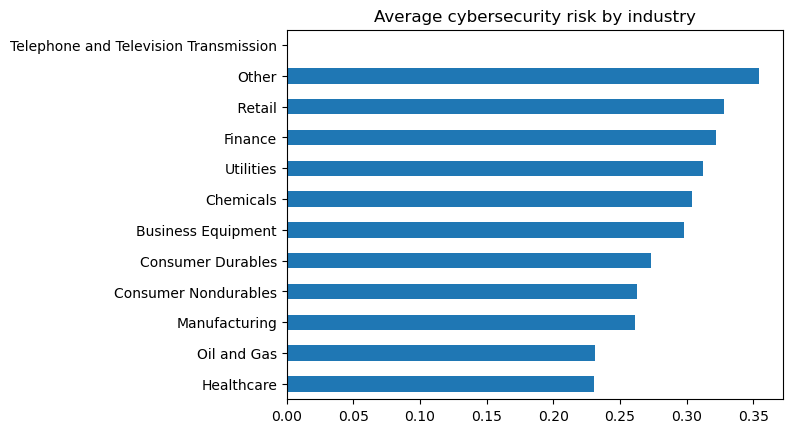

In [238]:
avg_cyber_industry = pd.DataFrame(avg_cyber_industry, index = ['Consumer Nondurables', 'Consumer Durables',
                                                                 'Manufacturing', 'Oil and Gas',
                                                                 'Chemicals', 'Business Equipment',
                                                                 'Telephone and Television Transmission',
                                                                 'Utilities', ' Retail', 'Healthcare',
                                                                 'Finance', 'Other'])
avg_cyber_industry.sort_values(0).plot.barh(legend = False)
plt.title('Average cybersecurity risk by industry')
plt.show()

In [56]:
#download yearly book values for all companies
book_value = db.get_table(library = 'comp', table = 'funda', columns = ['datadate', 'tic', 'ceq'])
book_value.columns = ['date', 'ticker','BV']
book_value = book_value[book_value.ticker.isin(stocknames.ticker)].drop_duplicates(subset = ['ticker','date'])
book_value.dropna(how = 'any', inplace = True)
book_value.date = pd.to_datetime(book_value.date)
book_value = book_value.pivot(index = 'date', columns = 'ticker', values = 'BV')
book_value = book_value.resample('Y').sum(min_count = 1)
book_value.index = book_value.index.year
book_value = book_value*1000000 #in millions on wrds
book_value

ticker,A,AA,AAC,AACC,AADI,AAI,AAIC,AAL,AAMC,AAME,...,ZUMZ,ZUO,ZVIA,ZVXI,ZWS,ZY,ZYME,ZYNE,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,4.748000e+09,4.112000e+09,NaN,NaN,NaN,NaN,NaN,-1.180000e+08,-207928000.0,118339000.0,...,400456000.0,152993000.0,-39969000.0,NaN,1.228600e+09,-499578000.0,245681000.0,75597000.0,19742000.0,NaN
2020,4.873000e+09,3.311000e+09,11000.0,NaN,NaN,NaN,210981000.0,-6.867000e+09,-166578000.0,145005000.0,...,466086000.0,164659000.0,-196812000.0,NaN,2.747300e+09,-743736000.0,409922000.0,60144000.0,56855000.0,NaN
2021,5.389000e+09,4.672000e+09,931343000.0,NaN,136406000.0,NaN,NaN,-7.340000e+09,-76528000.0,141231000.0,...,552596000.0,171913000.0,128452000.0,NaN,1.264000e+08,408486000.0,249094000.0,70914000.0,73925000.0,NaN


In [122]:
#compute yearly Return on assets (ROA) for all companies
#ROA = operating income before depreciation / Total assets
oper_income_b4_dep = db.get_table(library = 'comp', table = 'funda', columns = ['datadate', 'tic', 'oibdp'])
oper_income_b4_dep.columns = ['date', 'ticker','oper_income']
oper_income_b4_dep = oper_income_b4_dep[oper_income_b4_dep.ticker.isin(stocknames.ticker)].drop_duplicates(subset = ['ticker','date'])
oper_income_b4_dep.dropna(how = 'any', inplace = True)
oper_income_b4_dep.date = pd.to_datetime(oper_income_b4_dep.date)
oper_income_b4_dep = oper_income_b4_dep.pivot(index = 'date', columns = 'ticker', values = 'oper_income')
oper_income_b4_dep = oper_income_b4_dep.resample('Y').sum(min_count = 1)
oper_income_b4_dep.index = oper_income_b4_dep.index.year

total_assets = db.get_table(library = 'comp', table = 'funda', columns = ['datadate', 'tic', 'at'])
total_assets.columns = ['date', 'ticker','total_assets']
total_assets = total_assets[total_assets.ticker.isin(stocknames.ticker)].drop_duplicates(subset = ['ticker','date'])
total_assets.dropna(how = 'any', inplace = True)
total_assets.date = pd.to_datetime(total_assets.date)
total_assets = total_assets.pivot(index = 'date', columns = 'ticker', values = 'total_assets')
total_assets = total_assets.resample('Y').sum(min_count = 1)
total_assets.index = total_assets.index.year
total_assets = total_assets.replace(0, np.nan)

ROA = oper_income_b4_dep.div(total_assets)
ROA.clip(lower = -1, upper = 1, inplace = True) #lot of very extreme values
ROA

ticker,A,AA,AAC,AACC,AADI,AAI,AAIC,AAL,AAMC,AAME,...,ZUMZ,ZUO,ZVIA,ZVXI,ZWS,ZY,ZYME,ZYNE,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.251939,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.273183,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245845,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.240919,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.216418,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,0.134786,0.109835,NaN,NaN,NaN,NaN,NaN,0.100408,NaN,0.007200,...,0.163436,-0.220614,-0.171196,NaN,0.125686,-0.913265,-0.394096,-0.389517,0.418856,NaN
2020,0.139088,0.072948,-0.026769,NaN,NaN,NaN,NaN,-0.145497,NaN,0.044653,...,0.121345,-0.186977,-0.091000,NaN,0.100509,-0.727998,-0.339881,-0.700217,0.163782,NaN
2021,0.161233,0.182429,-0.006452,NaN,-0.221367,NaN,NaN,-0.047828,-0.200979,0.019121,...,0.125496,-0.138425,-0.691471,NaN,0.165445,-0.568840,-0.546095,-0.449946,0.184972,NaN


In [123]:
#save the monthly returns
save_path = '../data/returns/'
returns_df.to_csv(save_path + 'monthly_returns.csv.gz')
market_caps_df.to_csv(save_path + 'monthly_mkt_caps.csv.gz')
industry_codes_df.to_csv(save_path + 'industry_codes.csv.gz')
book_value.to_csv(save_path + 'book_values.csv.gz')
ROA.to_csv(save_path+'ROA.csv.gz')

## Portfolio analysis

In [5]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)

In [6]:
#read in all the necessary files
returns = pd.read_csv('../data/returns/monthly_returns.csv.gz', index_col = 'date')
returns.index = pd.to_datetime(returns.index)
mkt_caps = pd.read_csv('../data/returns/monthly_mkt_caps.csv.gz', index_col = 'date')
mkt_caps.index = pd.to_datetime(mkt_caps.index)
book_values = pd.read_csv('../data/returns/book_values.csv.gz', index_col = 'date')
ROA = pd.read_csv('../data/returns/ROA.csv.gz', index_col = 'date')
full_cyber_risk = pd.read_csv('../data/cyber_risk_measures/Florackis/cosine_sim_full.csv', index_col = 'date')
direct_cyber_risk = pd.read_csv('../data/cyber_risk_measures/Florackis/cosine_sim_dir.csv',index_col = 'date')
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)
FF5.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF,UMD
date,,,,,,,
2022-08-01,-0.0377,0.0149,0.0030,-0.0478,0.0130,0.0019,0.0199
2022-09-01,-0.0935,-0.0097,0.0006,-0.0151,-0.0084,0.0019,0.0347
2022-10-01,0.0783,0.0186,0.0805,0.0307,0.0652,0.0023,0.0387
2022-11-01,0.0460,-0.0267,0.0138,0.0601,0.0311,0.0029,-0.0201
2022-12-01,-0.0641,-0.0016,0.0132,0.0009,0.0419,0.0033,0.0452


In [126]:
#firms with zero risk = tercile 1
#rest 50% in tercile 2 and tercile 3
#construct portfolios at the end of each quarter
#cyber measure const between two filling dates
#get monthly excess returns

In [127]:
dates = pd.date_range(start = '01-01-2008', end = '01-01-2023', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
ew_low_tercile_returns = []
ew_middle_tercile_returns = []
ew_high_tercile_returns = []
vw_low_tercile_returns = []
vw_middle_tercile_returns = []
vw_high_tercile_returns = []
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_terciles = []

#drop firms with less than 3 years (table 7 caption)
full_cyber_risk = full_cyber_risk.loc[:,(~full_cyber_risk.isnull()).sum()>3]

for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cyber_risk_full = full_cyber_risk.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cyber_risk_full.index].dropna()
        Cyber_risk_full = Cyber_risk_full.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+2]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cyber_risk_full = Cyber_risk_full[Cyber_risk_full.index.isin(firms_with_ret)]
        
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cyber_risk_full.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cyber_risk_full.loc[idx_not_filled] = full_cyber_risk.loc[month.year-1,idx_not_filled]
        Cyber_risk_full.dropna(inplace = True)
        
        #sort firms into "terciles"
        low_tercile = Cyber_risk_full[Cyber_risk_full == 0].index.values
        Cyber_risk_full = Cyber_risk_full[Cyber_risk_full != 0]
        median = Cyber_risk_full.median()
        middle_tercile = Cyber_risk_full[Cyber_risk_full <= median].index.values
        high_tercile = Cyber_risk_full[Cyber_risk_full > median].index.values
        
        nb_firms.append([len(low_tercile),len(middle_tercile),len(high_tercile)])
        
        #value weighted portfolio weights
        low_tercile_weights = mkt_caps_.loc[low_tercile].div(mkt_caps_.loc[low_tercile].sum())
        middle_tercile_weights = mkt_caps_.loc[middle_tercile].div(mkt_caps_.loc[middle_tercile].sum())
        high_tercile_weights = mkt_caps_.loc[high_tercile].div(mkt_caps_.loc[high_tercile].sum())
        
        mkt_values.append([np.log(mkt_caps_.loc[low_tercile]/1000).mean(), np.log(mkt_caps_.loc[middle_tercile]/1000).mean(),
                           np.log(mkt_caps_.loc[high_tercile]/1000).mean()])
        
        book_to_markets.append([book_values.loc[month.year,book_values.columns.isin(low_tercile)].div(mkt_caps_.loc[low_tercile]).mean(),
                                book_values.loc[month.year,book_values.columns.isin(middle_tercile)].div(mkt_caps_.loc[middle_tercile]).mean(),
                                book_values.loc[month.year,book_values.columns.isin(high_tercile)].div(mkt_caps_.loc[high_tercile]).mean()])
        ROAs.append([ROA.loc[month.year-1,ROA.columns.isin(low_tercile)].mean(),
                     ROA.loc[month.year-1,ROA.columns.isin(middle_tercile)].mean(),
                     ROA.loc[month.year-1,ROA.columns.isin(high_tercile)].mean()])
        
    low_tercile_ret = returns.loc[month, low_tercile]
    middle_tercile_ret = returns.loc[month, middle_tercile]
    high_tercile_ret = returns.loc[month, high_tercile]
    
    #equally weighted portfolios
    ew_low_tercile_returns.append(low_tercile_ret.mean())
    ew_middle_tercile_returns.append(middle_tercile_ret.mean())
    ew_high_tercile_returns.append(high_tercile_ret.mean())
    
    #value weighted portfolios
    #low_tercile_weights = mkt_caps.loc[dates[i-1], low_tercile].div(mkt_caps.loc[dates[i-1], low_tercile].sum())
    #middle_tercile_weights = mkt_caps.loc[dates[i-1], middle_tercile].div(mkt_caps.loc[dates[i-1], middle_tercile].sum())
    #high_tercile_weights = mkt_caps.loc[dates[i-1], high_tercile].div(mkt_caps.loc[dates[i-1], high_tercile].sum())
    vw_low_tercile_returns.append(low_tercile_ret.multiply(low_tercile_weights).sum())
    vw_middle_tercile_returns.append(middle_tercile_ret.multiply(middle_tercile_weights).sum())
    vw_high_tercile_returns.append(high_tercile_ret.multiply(high_tercile_weights).sum())
    
    #mkt_values.append([mkt_caps.loc[dates[i-1], low_tercile].mean(), mkt_caps.loc[dates[i-1], middle_tercile].mean(),
                       #mkt_caps.loc[dates[i-1], high_tercile].mean()])
    risk_index_terciles.append([0,Cyber_risk_full.loc[middle_tercile].mean(),Cyber_risk_full.loc[high_tercile].mean()])

ew_low_tercile_returns = pd.DataFrame(ew_low_tercile_returns, index = dates,columns = ['low_tercile_ret'])
ew_middle_tercile_returns = pd.DataFrame(ew_middle_tercile_returns, index = dates,columns = ['middle_tercile_ret'])
ew_high_tercile_returns = pd.DataFrame(ew_high_tercile_returns, index = dates,columns = ['high_tercile_ret'])

vw_low_tercile_returns = pd.DataFrame(vw_low_tercile_returns, index = dates,columns = ['low_tercile_ret'])
vw_middle_tercile_returns = pd.DataFrame(vw_middle_tercile_returns, index = dates,columns = ['middle_tercile_ret'])
vw_high_tercile_returns = pd.DataFrame(vw_high_tercile_returns, index = dates,columns = ['high_tercile_ret'])

In [128]:
table, pval_table = get_alphas(ew_low_tercile_returns, ew_middle_tercile_returns, ew_high_tercile_returns, FF5)
print('Equally weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))

Equally weighted portfolios


,T1 (low),T2,T3 (high),T3-T1
Excess return,0.90%,0.93%,1.00%,0.10%
CAPM alpha,0.04%,0.01%,0.08%,0.04%
FFC alpha,0.16%,0.12%,0.19%,0.03%
FF5 alpha,0.26%,0.18%,0.22%,-0.05%


p-values:


,T1 (low),T2,T3 (high),T3-T1
Excess return,0.126,0.065,0.049,0.529
CAPM alpha,0.885,0.967,0.631,0.804
FFC alpha,0.407,0.253,0.020,0.876
FF5 alpha,0.280,0.241,0.043,0.801


In [129]:
table, pval_table = get_alphas(vw_low_tercile_returns, vw_middle_tercile_returns, vw_high_tercile_returns, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))

Value weighted portfolios


,T1 (low),T2,T3 (high),T3-T1
Excess return,0.94%,0.86%,0.77%,-0.17%
CAPM alpha,0.21%,0.11%,-0.01%,-0.21%
FFC alpha,0.19%,0.14%,-0.02%,-0.21%
FF5 alpha,0.20%,0.03%,0.01%,-0.19%


p-values:


,T1 (low),T2,T3 (high),T3-T1
Excess return,0.015,0.013,0.041,0.199
CAPM alpha,0.084,0.425,0.944,0.164
FFC alpha,0.080,0.216,0.741,0.152
FF5 alpha,0.068,0.729,0.893,0.173


In [130]:
tableB = pd.DataFrame(np.ones([5,3]), index = ['Number of firms', 'Cybersecurity risk index', 'Market Value (ln)',
                                               'Book-to-Market', 'ROA'],
                      columns = ['T1 (low)', 'T2', 'T3 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cybersecurity risk index',:] = np.mean(risk_index_terciles, axis = 0)
tableB.loc['Market Value (ln)',:] = np.mean(mkt_values, axis = 0)
tableB.loc['Book-to-Market',:] = np.mean(book_to_markets, axis = 0)
tableB.loc['ROA',:] = np.nanmean(ROAs, axis = 0)

tableB.style.format("{:.3f}")

,T1 (low),T2,T3 (high)
Number of firms,871.700,1054.883,1054.267
Cybersecurity risk index,0.000,0.348,0.477
Market Value (ln),12.470,13.543,14.005
Book-to-Market,0.787,0.655,0.608
ROA,-0.018,0.017,0.078


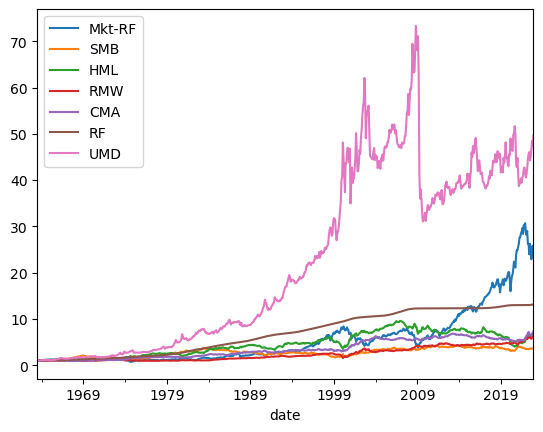

In [61]:
(FF5+1).cumprod(0).plot()
plt.show()

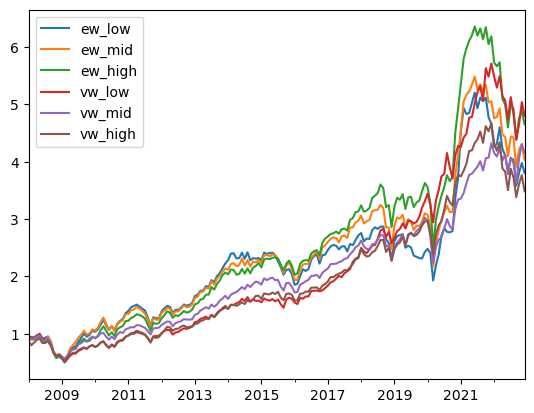

In [62]:
test = pd.concat([ew_low_tercile_returns, ew_middle_tercile_returns, ew_high_tercile_returns,
                  vw_low_tercile_returns, vw_middle_tercile_returns, vw_high_tercile_returns],axis = 1)
test.columns = ['ew_low','ew_mid','ew_high','vw_low','vw_mid','vw_high']
(test+1).cumprod(0).plot()
plt.show()

In [175]:
db.close()